In [1]:
import csv

In [20]:
# Remove body of questions and answers
f = open('./data/stacksample/questions_cleaned.csv', 'w')
w = csv.writer(f)
with open('./data/stacksample/Questions.csv', errors = 'ignore') as file:
    file_data = csv.reader(file)
    for line in file_data:
        w.writerow(line[:-1])

In [22]:
f = open('./data/stacksample/answers_cleaned.csv', 'w')
w = csv.writer(f)
with open('./data/stacksample/Answers.csv', errors = 'ignore') as file:
    file_data = csv.reader(file)
    for line in file_data:
        w.writerow(line[:-1])

In [2]:
# Parse HTML
from html.parser import HTMLParser
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter

stoplist = stopwords.words('english')

class Parser(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def clean(html):
    s = Parser()
    s.feed(html)
    html_text = re.sub("[^a-zA-Z]", " ", s.get_data())
    words = html_text.lower().split()   
    return({word: count for word, count in Counter(words).items() if not word in stoplist})

In [7]:
f = open('./data/stacksample/questions_body.csv', 'w')
w = csv.writer(f)
w.writerow(['Id', 'Body'])
with open('./data/stacksample/Questions.csv', errors = 'ignore') as file:
    file_data = csv.reader(file)
    headers = next(file_data, None)
    for line in file_data:
        id = line[0]
        body = clean(line[-1])
        w.writerow([id, body])

In [9]:
f = open('./data/stacksample/answers_body.csv', 'w')
w = csv.writer(f)
w.writerow(['Id', 'ParentId', 'Body'])
with open('./data/stacksample/Answers.csv', errors = 'ignore') as file:
    file_data = csv.reader(file)
    headers = next(file_data, None)
    for line in file_data:
        id = line[0]
        parentid = line[3]
        body = clean(line[-1])
        w.writerow([id, parentid, body])

In [14]:
import sqlite3

conn = sqlite3.connect('./data/stacksample/stacksample.db')
c = conn.cursor()

In [32]:
# Relationship between average score of questions and answers for users

c.execute('''SELECT q.OwnerUserId, q.qScore, a.aScore
             FROM (SELECT OwnerUserId, AVG(Score) AS qScore
                   FROM questions
                   GROUP BY OwnerUserId) AS q
             INNER JOIN (SELECT OwnerUserId, AVG(Score) AS aScore
                         FROM answers
                         GROUP BY OwnerUserId) AS a
             ON q.OwnerUserId=a.OwnerUserId
             ''')

In [33]:
userScore = pd.DataFrame(c.fetchall(), columns = ['UserId', 'qAvgScore', 'aAvgScore'])
userScore.head()

,UserId,qAvgScore,aAvgScore
0,1,19.333333,17.846154
1,4,26.333333,2.736842
2,5,6.250000,7.961538
3,9,2.000000,3.500000
4,17,5.000000,4.857143


In [37]:
from scipy.stats.stats import pearsonr

pearsonr(userScore['qAvgScore'], userScore['aAvgScore'])

(0.099529633180696811, 0.0)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

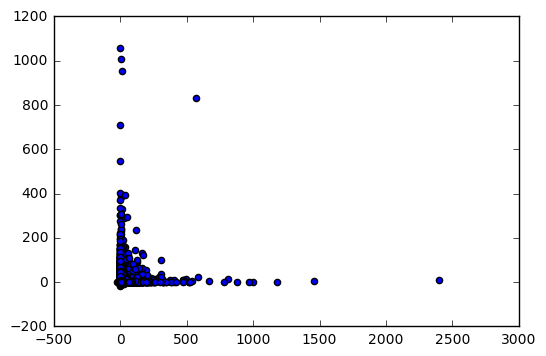

In [36]:
plt.figure()
plt.scatter(userScore['qAvgScore'], userScore['aAvgScore'])
plt.show()

In [15]:
# Relationship between question score and number of answers

c.execute('''SELECT COUNT(a.ParentId)
             FROM questions q LEFT JOIN answers a
             ON q.Id=a.ParentId
             GROUP BY q.Id
             ORDER BY q.Id''')
answer_count = [row[0] for row in c.fetchall()]

In [16]:
import pandas as pd

q_clean = pd.read_csv('./data/stacksample/questions_cleaned.csv')
a_clean = pd.read_csv('./data/stacksample/answers_cleaned.csv')
tags = pd.read_csv('./data/stacksample/Tags.csv')
q_clean['AnswerCount'] = answer_count

In [17]:
q_clean.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,AnswerCount
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,3
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,3
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,1
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,9
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,9


In [38]:
pearsonr(q_clean['Score'], q_clean['AnswerCount'])

(0.30222293177158693, 0.0)

In [58]:
# Tags of questions with most answers

mostAnsweredId = q_clean.query('AnswerCount > 10')['Id'].tolist()
mostAnsweredTags = tags[tags['Id'].isin(mostAnsweredId)]
mostAnsweredTags.head()

,Id,Tag
24,580,sql-server
25,580,sql-server-2005
26,580,deployment
27,580,release-management
45,1160,svn


In [82]:
from collections import Counter

counter = Counter(mostAnsweredTags['Tag'])
tagsCounts = pd.DataFrame.from_dict(counter, orient='index').reset_index()
tagsCounts = tagsCounts.rename(columns={'index':'tag', 0:'count'})
tagsCounts = tagsCounts.sort_values('count', ascending = False)

In [84]:
tagsCounts.head(10)

,tag,count
220,java,292
1010,c#,247
1637,javascript,185
1638,c++,182
521,android,139
1252,php,127
1168,jquery,120
185,.net,118
947,c,117
582,python,113
